Preprocessing and QA of pupil data
===================

  1. Load pupil data from edf->df gzips. 
  2. Plot #sessions per subject and compare to corrupt EDFs
  3. Clean pupil data
  4. Plot some example data from each subject

In [2]:
import cPickle
from conf_analysis import pupil, patsy_transforms as pt
from pylab import *
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import gzip
# Load data from all subs
def get_data(sub):
    data = cPickle.load(gzip.open('../temp_data/' + sub+'.pickle.gzip'))
    events, messages = data['events'], data['messages']
    events = events.reset_index()
    del events['level_0']
    del events['level_1']
    events.rename(columns={'level_2':'sample_time'}, inplace=True)
    events['sample_time'] = events.sample_time.astype(int)
    events['subject'] = sub
    events.set_index(['session', 'block', 'subject', 'sample_time'], inplace=True)    
    messages.feedback[messages.feedback==0] = -1
    messages['subject'] = sub
    messages = messages.reset_index()
    del messages['level_0']
    del messages['level_1']
    del messages['level_2']
    messages.set_index(['session', 'block', 'subject', 'trial'], inplace=True)    
    #def zscore(ev):
    #    ev['pa'] = (ev.pa-ev.pa.mean())/ev.pa.std()
    #    return ev
    #events = events.groupby(level='session').apply(zscore)
    return events, messages

In [4]:
events, messages = [], []
for sub in ['S%02i'%i for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14]]:
    e, m = get_data(sub)
    events.append(e)
    messages.append(m)
events = pd.concat(events)
events["sfname"] = events["sfname"].astype('category')
messages = pd.concat(messages)

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
messages.sort_index(inplace=True)
events.sort_index(inplace=True)
print messages.index.names, messages.index.lexsort_depth
print events.index.names, events.index.lexsort_depth
messages = messages.loc[~isnan(messages.decision_time)]

[u'session', u'block', u'subject', u'trial'] 4
[u'session', u'block', u'subject', u'sample_time'] 4


In [6]:
events.to_hdf('../temp_data/allevents.h5', key='events', mode='w', complib='blosc', format='table')
messages.to_hdf('../temp_data/allmessages.h5', key='messages', mode='a', complib='blosc', format='fixed')

/Users/nwilming/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:939: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['contrast', 'contrast_time', 'trialid ']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [7]:
from pyedfread import edfread
from conf_analysis import datadef
corrupt = dict((k, []) for k in datadef.sb2fname.keys())
for s in range(1, 15):
    for session, vals in datadef.sb2fname['S%02i'%s].iteritems():
        for block, (edf, mat) in vals.iteritems():
            try:
                edfread.read_preamble(edf)
            except:
                corrupt['S%02i'%s].append(edf)

/Users/nwilming/u/conf_data/S01/s01_20151208T085245.edf  could not be openend.
/Users/nwilming/u/conf_data/S01/s01_20151208T090536.edf  could not be openend.
/Users/nwilming/u/conf_data/S01/s01_20151208T092326.edf  could not be openend.
/Users/nwilming/u/conf_data/S01/s01_20151208T093411.edf  could not be openend.
/Users/nwilming/u/conf_data/S03/s03_20151208T150434.edf  could not be openend.
/Users/nwilming/u/conf_data/S03/s03_20151208T154258.edf  could not be openend.
/Users/nwilming/u/conf_data/S03/s03_20151208T155344.edf  could not be openend.
/Users/nwilming/u/conf_data/S03/s03_20151217T123517.edf  could not be openend.
/Users/nwilming/u/conf_data/S03/s03_20151217T131409.edf  could not be openend.
/Users/nwilming/u/conf_data/S05/s05_20151217T163010.edf  could not be openend.
/Users/nwilming/u/conf_data/S06/s06_20151217T142315.edf  could not be openend.
/Users/nwilming/u/conf_data/S06/s06_20151217T151256.edf  could not be openend.
/Users/nwilming/u/conf_data/S06/s06_20151218T123104.

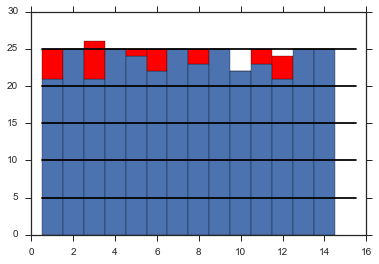

In [8]:
for sub in range(1, 15):
    try:
        nsession = len(events.xs('S%02i'%sub, level='subject').groupby(level=['session', 'block']))
        bar(sub-0.5, nsession, 1)
        lc = len(corrupt['S%02i'%sub])
        bar(sub-0.5, lc, bottom=nsession, width=1, color='r')
    except Exception as e :
        print e
for k in [5, 10, 15, 20, 25]:
    plot([0.5, 15.5], [k,k], 'k-')

What is missing:
---------------
    - S1: Complete but 4 files corrupt.
    - S2: Complete
    - S3: 26 files available. 5 Corrupt!
    - S4: Complete!
    - S5: 25 files in datadef, 1 corrupt!
    - S6: 25 files in datadef, 3 corrupt!
    - S7: Complete!
    - S8: 2 Corrupt
    - S9: Complete!
    - S10: One measurement had to be aborted because of license issues, one file was not saved.
    - S11: 2 Corrupt files. 
    - S12: 4 Corrupt files. 
    - S13 + S14: Complete!

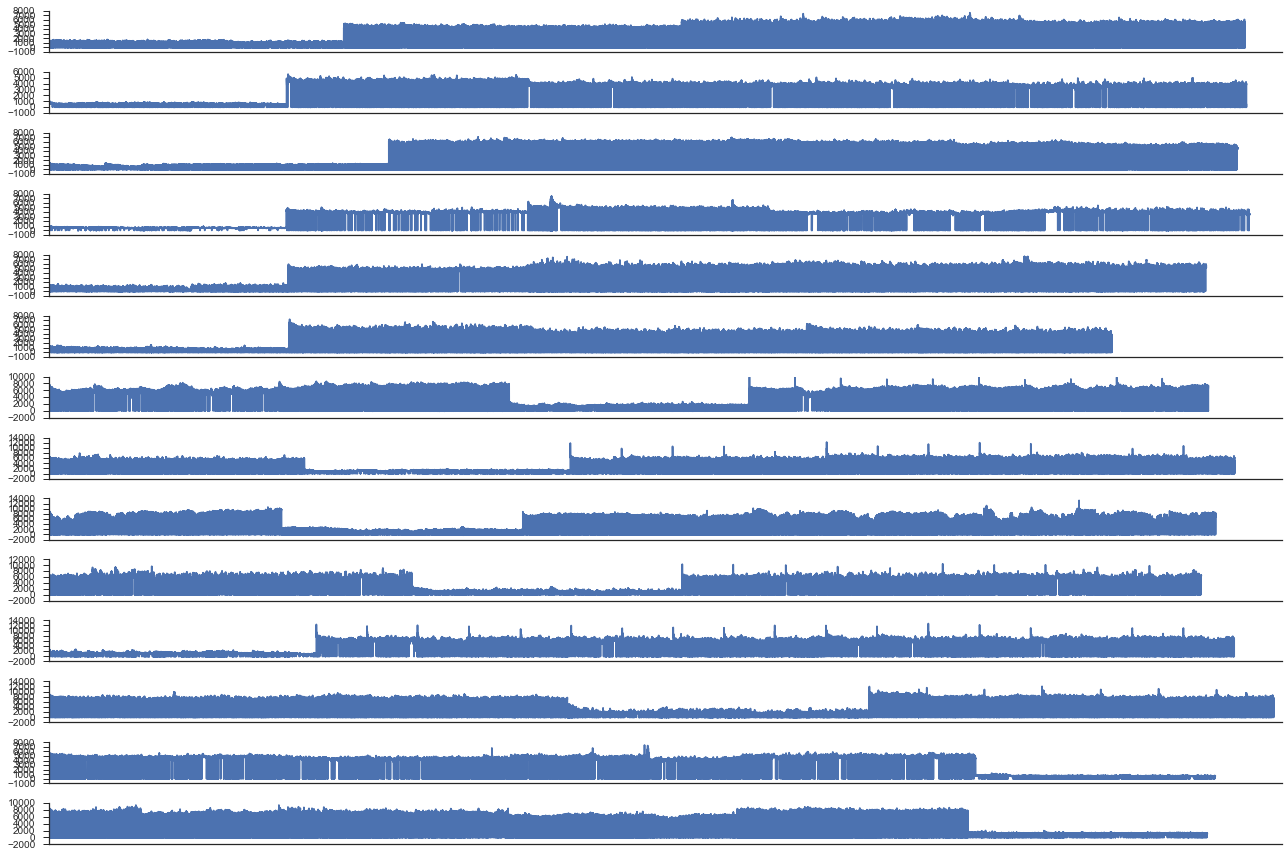

In [9]:
figure(figsize=(18,12))
for i, (snum, sdata) in enumerate(events.groupby(level='subject')):
    subplot(14, 1, i+1)
    plot(sdata.pa.values)
    xticks([])
sns.despine()
tight_layout()

In [10]:
def zscore(events):
    events = events - events.mean()
    events = events/events.std()
    return events
events = events.groupby('sfname').apply(pupil.cleanup)
events.pac = events.groupby('sfname').pac.apply(zscore)

In [11]:
events.to_hdf('../temp_data/allevents.h5', key='events', mode='w', complib='blosc', format='table')
messages.to_hdf('../temp_data/allmessages.h5', key='messages', mode='w', complib='blosc', format='fixed')

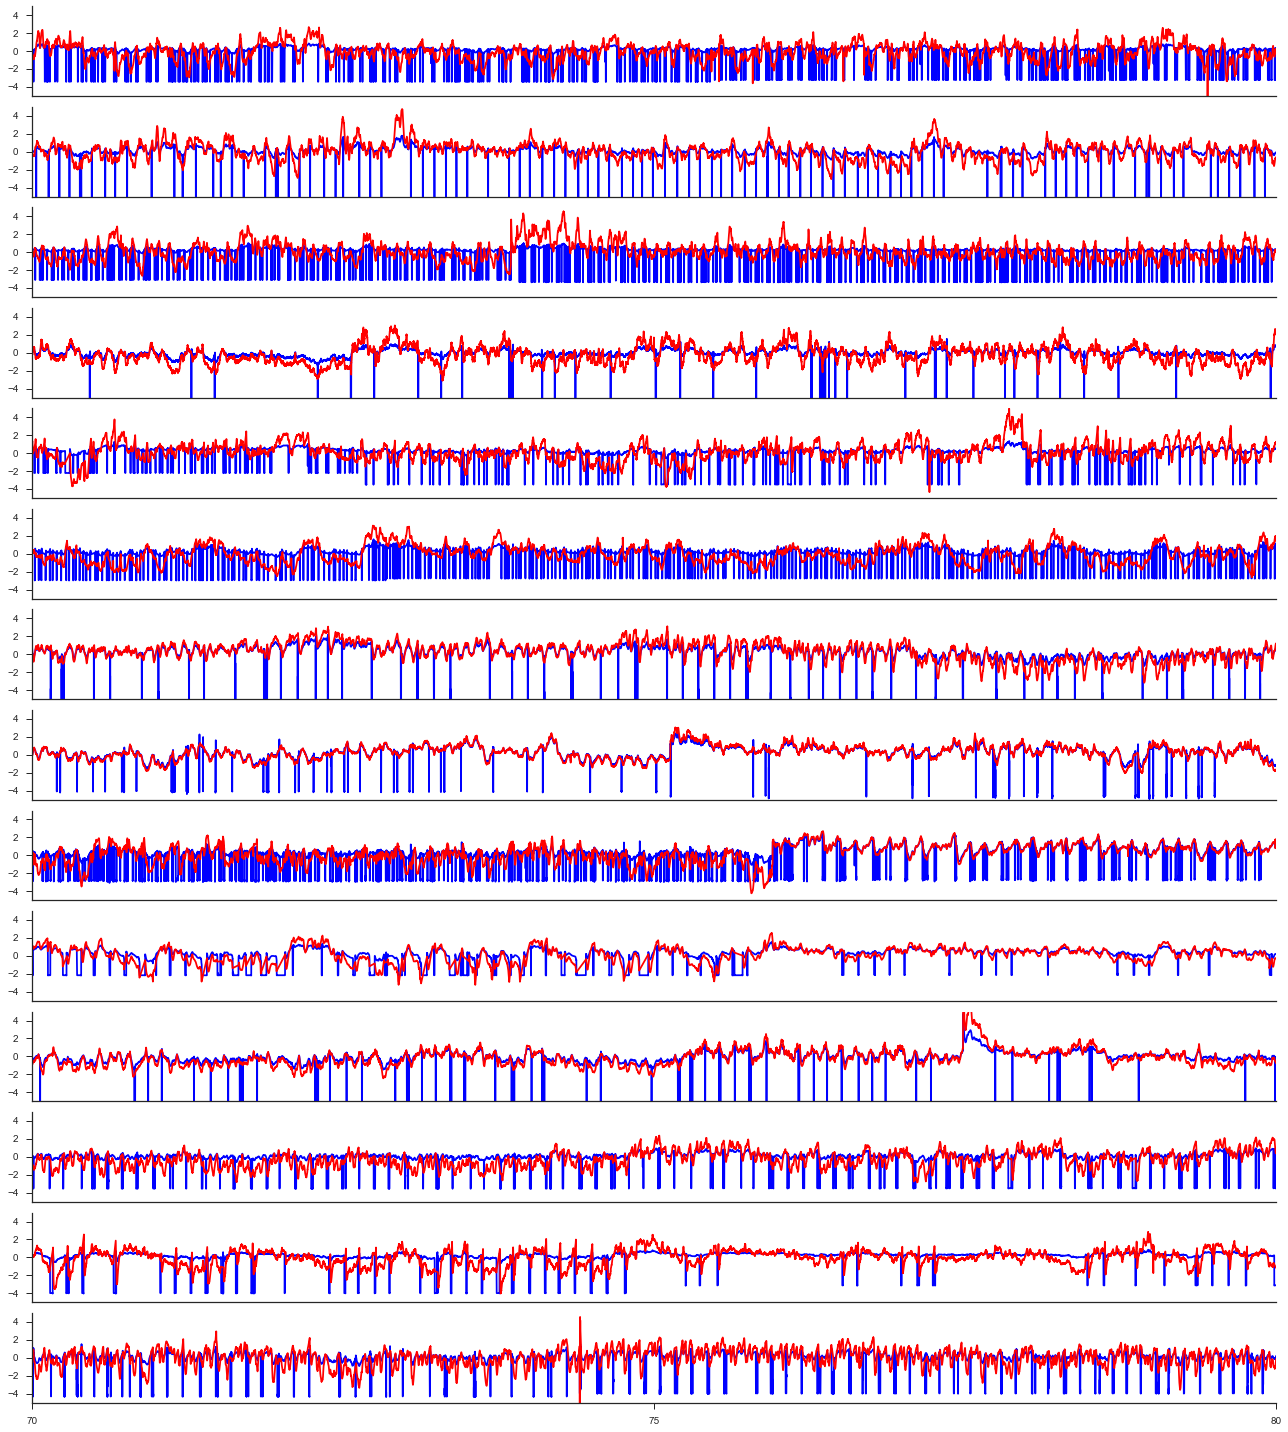

In [12]:
events.pa = events.groupby('sfname').pa.apply(zscore)
figure(figsize=(18, 20))
for i, (snum, sdata) in enumerate(events.groupby(level='subject')):
    subplot(14, 1, i+1)
    plot(arange(len(sdata.pa))/100./60., sdata.pa.values, 'b')
    plot(arange(len(sdata.pac))/100./60., sdata.pac.values, 'r')
    ylim(-5, 5)
    xlim([70, 80])
    xticks([])
sns.despine()
xticks([70, 75, 80])
tight_layout()
#ylim([-2.5, 2.5])